## Cleaning and Preparing Data

### Importing dataset & pandas

In [121]:
import pandas as pd

# Change to local path to data
path = "C://Users//User//Documents//Python Scripts//Data//tripadvisor_hotel_reviews.csv"
data = pd.read_csv(path)

# Dataset has 20,491 reviews
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### Cleaning out punctuation & creating a new column to classify reviews as positive or negative

In [122]:
data["Review"] = data["Review"].str.replace(r"[^\w\s]+", '')

data["Attitude"] = ["Positive" if i > 2 else "Negative" for i in data["Rating"]]

# 84% of comments are rated Positive while the remaining 16% are negative
data.head()

,Review,Rating,Attitude
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4 experience hotel monaco seatt...,3,Positive
3,unique great stay wonderful time hotel monaco ...,5,Positive
4,great stay great stay went seahawk game awesom...,5,Positive


### Spliting train and test data

In [123]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = .33, random_state = 10, stratify = data["Attitude"], shuffle = True)

train = train.iloc[:,[0,2]]
print(len(test), ",", len(train))

6763 , 13728


### Vectorize the review strings

In [124]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
trained_vec = vect.fit_transform(train["Review"])

test_vecs = vect.transform(test["Review"])

# Classifiying

### Linear SVM

In [125]:
from sklearn import svm

svm_ = svm.SVC(kernel = "linear")
svm_.fit(trained_vec, train["Attitude"])

print(svm_.predict(test_vecs[0]))

['Positive']


#### Was the classification correct? It correctly guessed that the 4 star review below was indeed positve

In [126]:
print(test.head(1))

                                                  Review  Rating  Attitude
11370  nicer read husband stayed water beach hotel su...       4  Positive


### Logistic Regression

In [127]:
from sklearn.linear_model import LogisticRegression

log_ = LogisticRegression(solver='lbfgs', max_iter = 2000)
log_.fit(trained_vec, train["Attitude"])

print(log_.predict(test_vecs[0]))

['Positive']


### Multinomial Naive Bayes

In [136]:
from sklearn.naive_bayes import MultinomialNB

multi_ = MultinomialNB()
multi_.fit(trained_vec, train["Attitude"])

print(multi_.predict(test_vecs[0]))

['Positive']


### Decision Trees

In [129]:
from sklearn.tree import DecisionTreeClassifier

dec_ = DecisionTreeClassifier()
dec_.fit(trained_vec, train["Attitude"])

print(dec_.predict(test_vecs[0]))

['Positive']


## Scoring Results

### Now to Compare Mean Accuracy

In [130]:
svm_mean_score_1 = round(svm_.score(test_vecs, test["Attitude"]), 4)
log_mean_score_1 = round(log_.score(test_vecs, test["Attitude"]), 4)
multi_mean_score_1 = round(multi_.score(test_vecs, test["Attitude"]), 4)
dec_mean_score_1 = round(dec_.score(test_vecs, test["Attitude"]), 4)


print(svm_mean_score_1)
print(log_mean_score_1)
print(multi_mean_score_1)
print(dec_mean_score_1)

0.9129
0.9203
0.9196
0.8622


### F1 Score Comparison

In [131]:
from sklearn.metrics import f1_score
from numpy import around as around


f1_svm_1 = around(f1_score(test["Attitude"], svm_.predict(test_vecs), average = None, 
                           labels = ["Positive", "Negative"]), 4)
f1_log_1 = around(f1_score(test["Attitude"], log_.predict(test_vecs), average = None, 
                           labels = ["Positive", "Negative"]), 4)
f1_multi_1 = around(f1_score(test["Attitude"], multi_.predict(test_vecs), average = None, 
                             labels = ["Positive", "Negative"]), 4)
f1_dec_1 = around(f1_score(test["Attitude"], dec_.predict(test_vecs), average = None, 
                           labels = ["Positive", "Negative"]), 4)


print(f1_svm_1)
print(f1_log_1)
print(f1_multi_1)
print(f1_dec_1)

[0.9485 0.7172]
[0.9532 0.7328]
[0.9537 0.6937]
[0.9191 0.5345]


### It seems that Multinomial Naive Bayes SVM and Logistic Regression  has the highest mean and F1 scores! Lets see how these models performs on some test data we create.

In [132]:
fake_test = ["Worst ever", "love it", "terrible", 'Great service', 'hate this place']
round2 = vect.transform(fake_test)

print(svm_.predict(round2))
print(log_.predict(round2))
print(multi_.predict(round2))

['Negative' 'Positive' 'Negative' 'Positive' 'Positive']
['Negative' 'Positive' 'Negative' 'Positive' 'Positive']
['Negative' 'Positive' 'Negative' 'Positive' 'Positive']


### Why does the modeld think the last example is positive? Upon further inspection of the dataset, the word "hate" was not used exclusively as a negative. instead many positive reviews used the word. This and other oddities can be corrected with a larger training data set. The discrepency can be seen below

In [133]:
fake_test2 = ["I HATE THIS", "HATE LIVING HERE", "HATED THIS PLACE", 'HATED THE SERVICE']
round3 = vect.transform(fake_test2)

print(svm_.predict(round3))
print(log_.predict(round3))
print(multi_.predict(round3))

['Positive' 'Positive' 'Positive' 'Positive']
['Positive' 'Positive' 'Positive' 'Positive']
['Positive' 'Negative' 'Positive' 'Positive']


## TFID Vectorizer

### The earlier count vectorizer gives equal weight to all words appearing in a review. Therefore prepositions, articles, nouns and other non-descriptive words are given a much higher weight in determining the "attitude" of a review just because they occur more frequently in speech. For example, in the below, the words "I", "this" and "place" are given the same weight in the model as the words "love" and "hate.

In [43]:
# 'I hate this place'
# 'I love this place'

# The words that actually matter ('love' & 'hate') should be given more weight than all the other words. 
# Therefore using a TFID vectorizer will correct this as instead of giving more weight to words that 
# occur more frequently, it will assign greater weight to words that occur more RARELY 

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Re-vectorizing with TFID
vect2 = TfidfVectorizer()
trained_vec2 = vect2.fit_transform(train["Review"])

test_vecs2 = vect2.transform(test["Review"])

# Re-modelling with new vectorizor
svm_2 = svm.SVC(kernel = "linear")
svm_2.fit(trained_vec2, train["Attitude"])

log_2 = LogisticRegression(solver='lbfgs')
log_2.fit(trained_vec2, train["Attitude"])

multi_2 = MultinomialNB()
multi_2.fit(trained_vec2, train["Attitude"])

dec_2 = DecisionTreeClassifier()
dec_2.fit(trained_vec2, train["Attitude"])

# New F1 Scores
f1_svm_2 = around(f1_score(test["Attitude"], svm_2.predict(test_vecs2), average = None, 
                           labels = ["Positive", "Negative"]), 4)
f1_log_2 = around(f1_score(test["Attitude"], log_2.predict(test_vecs2), average = None, 
                           labels = ["Positive", "Negative"]), 4)
f1_multi_2 = around(f1_score(test["Attitude"], multi_2.predict(test_vecs2), average = None, 
                             labels = ["Positive", "Negative"]), 4)
f1_dec_2 = around(f1_score(test["Attitude"], dec_2.predict(test_vecs2), average = None, 
                           labels = ["Positive", "Negative"]), 4)

print(f1_svm_2)
print(f1_log_2)
print(f1_multi_2)
print(f1_dec_2)

[0.9574 0.7454]
[0.9538 0.6965]
[0.9149 0.    ]
[0.9075 0.4938]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [144]:
# New mean performance scores
svm_mean_score_2 = round(svm_2.score(test_vecs2, test["Attitude"]), 4)
log_mean_score_2 = round(log_2.score(test_vecs2, test["Attitude"]), 4)
multi_mean_score_2 = round(multi_2.score(test_vecs2, test["Attitude"]), 4)
dec_mean_score_2 = round(dec_2.score(test_vecs2, test["Attitude"]), 4)

print(svm_mean_score_2)
print(log_mean_score_2)
print(multi_mean_score_2)
print(dec_mean_score_2)

0.927
0.9199
0.8431
0.8436


In [145]:
print("svm performance difference from basic vectorizing to TFID:\nmean score "
      , round((svm_mean_score_2 - svm_mean_score_1), 4),"\nf1 scores: ", around((f1_svm_2 - f1_svm_1), 4), "\n")
print("logistic performance difference from basic vectorizing to TFID:\nmean score "
      , round((log_mean_score_2 - log_mean_score_1), 4),"\nf1 scores: ", around((f1_log_2 - f1_log_1), 4), "\n")
print("multi NB performance difference from basic vectorizing to TFID:\nmean score "
      , round((multi_mean_score_2 - multi_mean_score_1), 4),"\nf1 scores: ", around((f1_multi_2 - f1_multi_1), 4), "\n")
print("decision tree NB performance difference from basic vectorizing to TFID:\nmean score "
      , round((dec_mean_score_2 - dec_mean_score_1), 4),"\nf1 scores: ", around((f1_dec_2 - f1_dec_1), 4))

svm performance difference from basic vectorizing to TFID:
mean score  0.0141 
f1 scores:  [0.0089 0.0282] 

logistic performance difference from basic vectorizing to TFID:
mean score  -0.0004 
f1 scores:  [ 0.0006 -0.0363] 

multi NB performance difference from basic vectorizing to TFID:
mean score  -0.0765 
f1 scores:  [-0.0388 -0.6937] 

decision tree NB performance difference from basic vectorizing to TFID:
mean score  -0.0186 
f1 scores:  [-0.0116 -0.0407]


## Paramater Tuning

### it seems that the increase in accuracy was nominal for the SVM model, lowered slightly for the logistic regression and vastly degraded for the Multinomial Bayes. Lets try parameter tuning using GridSearch to see if we can get a more substantial increase! (We will drop the decision tree model as it is seeing poorer results)

#### first for SVM (this takes a very long time!)

In [151]:
from sklearn.model_selection import GridSearchCV

test_params = {"C": (1, 2, 4), "kernel": ("linear", "poly", "rbf"), "gamma": ["scale"]}

svc_3 = svm.SVC()
svc_clf = GridSearchCV(svc_3, test_params, cv = 3)

svc_clf.fit(trained_vec2, train["Attitude"])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': (1, 2, 4), 'gamma': ['scale'],
                         'kernel': ('linear', 'poly', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [152]:
svm_mean_score_3 = round(svc_clf.score(test_vecs2, test["Attitude"]), 4)
f1_svm_3 = around(f1_score(test["Attitude"], svc_clf.predict(test_vecs2), average = None, 
                           labels = ["Positive", "Negative"]), 4)

#### For logistic regression 

In [147]:
test_params_log = {"solver":("newton-cg", "lbfgs", "liblinear", "sag", "saga")}

log_3 = LogisticRegression(solver='lbfgs')
log_clf = GridSearchCV(log_3, test_params_log, cv = 3)

log_clf.fit(trained_vec2, train["Attitude"])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [148]:
log_mean_score_3 = round(log_clf.score(test_vecs2, test["Attitude"]), 4)
f1_log_3 = around(f1_score(test["Attitude"], log_clf.predict(test_vecs2), average = None, 
                           labels = ["Positive", "Negative"]), 4)

#### for Multinomial Naive Bayes

In [149]:
test_params_multi = {"alpha": (0.5, 1.0, 2.0)}

multi3 = MultinomialNB()
multi_clf = GridSearchCV(multi3, test_params_multi, cv = 3)

multi_clf.fit(trained_vec2, train["Attitude"])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None, param_grid={'alpha': (0.5, 1.0, 2.0)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [150]:
multi_mean_score_3 = round(multi_clf.score(test_vecs2, test["Attitude"]), 4)
f1_multi_3 = around(f1_score(test["Attitude"], multi_clf.predict(test_vecs2), average = None, 
                           labels = ["Positive", "Negative"]), 4)

#### As we can see below there has been very little model improvement after parameter tuning. Only the multinomial naive bayes had any change

In [153]:
print("svm performance difference from base TFID models to paramater tuned models:\nmean score "
      , round((svm_mean_score_3 - svm_mean_score_2), 4),"\nf1 scores: ", around((f1_svm_3 - f1_svm_2), 4), "\n")
print("logistic performance difference from base TFID models to paramater tuned models:\nmean score "
      , round((log_mean_score_3 - log_mean_score_2), 4),"\nf1 scores: ", around((f1_log_3 - f1_log_2), 4), "\n")
print("multi performance difference from base TFID models to paramater tuned models:\nmean score "
      , round((multi_mean_score_3 - multi_mean_score_2), 4),"\nf1 scores: ", around((f1_multi_3 - f1_multi_2), 4), "\n")

svm performance difference from base TFID models to paramater tuned models:
mean score  0.0 
f1 scores:  [0. 0.] 

logistic performance difference from base TFID models to paramater tuned models:
mean score  0.0 
f1 scores:  [0. 0.] 

multi performance difference from base TFID models to paramater tuned models:
mean score  0.0011 
f1 scores:  [0.0005 0.0131] 



#### the SVM model below has produced the most accurate model and so is our final selection

In [154]:
print("final svm performance for TFID models post paramater tuning:\nmean score "
      , round((svm_mean_score_3), 4),"\nf1 scores: ", around((f1_svm_3), 4), "\n")
print("final logistic performance for TFID models post paramater tuning:\nmean score "
      , round((log_mean_score_3), 4),"\nf1 scores: ", around((f1_log_3), 4), "\n")
print("final multinomial naive bayesp performance for TFID models post paramater tuning:\nmean score "
      , round((multi_mean_score_3), 4),"\nf1 scores: ", around((f1_multi_3), 4), "\n")

final svm performance for TFID models post paramater tuning:
mean score  0.927 
f1 scores:  [0.9574 0.7454] 

final logistic performance for TFID models post paramater tuning:
mean score  0.9199 
f1 scores:  [0.9538 0.6965] 

final multinomial naive bayesp performance for TFID models post paramater tuning:
mean score  0.8442 
f1 scores:  [0.9154 0.0131] 



## Pickling the model

In [155]:
import pickle

# Change to local path to desired folder
with open('C://Users//User//Documents//Python Scripts//Data//SVM_review_classifer.pkl', 'wb') as file:
    pickle.dump(svc_clf, file)
    
with open('C://Users//User//Documents//Python Scripts//Data//SVM_review_classifer.pkl', 'rb') as file2:
    load_svm = pickle.load(file2)

In [175]:
print(test.iloc[0,0])
print("\nReview gave score of ", test.iloc[0,1],"\n")
print("prediction is:", load_svm.predict(test_vecs2[0])[0])

nicer read husband stayed water beach hotel sunday june 15 thursday june 19th 6th wedding anniversary sunday thursday key stay week no weekends want experience nice hotel noise rooftop bar guest complained really enjoyed rooms little cramped nice clean staff nice pleasant door man beach valet nice men extremely helpfulthe nicest experience hotel rooftop pool lounge area perfect romantic way relax able enjoy drinks food hotel pretty costly thing somewhat unpleased  

Review gave score of  4 

prediction is: Positive


## A Confusion Matrix to show accuracy

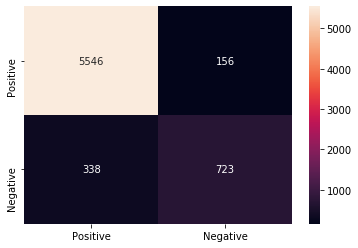

In [179]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

preds = load_svm.predict(test_vecs2)

labels = ["Positive", "Negative"]
matrix = confusion_matrix(test["Attitude"], preds, labels = labels)
matrix_df = pd.DataFrame(matrix, index = labels, columns = labels)

sn.heatmap(matrix_df, annot = True, fmt = "d")

plt.show()

### To get better accuracy, need a dataset with more negative reviews to test the data on. Here, negative reviews accounted for only 16% of the dataset causing our models to skew towards predicting "Positive" outcomes 